### 📥 Importing Libraries ###

In [ ]:
import os
os. chdir('../')
os.getcwd()

'c:\\DS projects\\Weather-Image-Classification'

In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
import numpy as np
import pickle
import json

### 🗃️ Load Dataset ###

In [3]:
path = '/content/drive/MyDrive/dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))
path_imgs[0:5]

['/content/drive/MyDrive/dataset/rime/5236.jpg',
 '/content/drive/MyDrive/dataset/rime/5066.jpg',
 '/content/drive/MyDrive/dataset/rime/4999.jpg',
 '/content/drive/MyDrive/dataset/rime/5048.jpg',
 '/content/drive/MyDrive/dataset/rime/5233.jpg']

In [4]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_imgs))
images = pd.Series(path_imgs, name='Images').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([images, labels],axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

Images Labels
0   /content/drive/MyDrive/dataset/rime/5424.jpg   rime
1   /content/drive/MyDrive/dataset/snow/1358.jpg   snow
2  /content/drive/MyDrive/dataset/frost/3646.jpg  frost
3   /content/drive/MyDrive/dataset/hail/0393.jpg   hail
4   /content/drive/MyDrive/dataset/rain/1486.jpg   rain

In [5]:
data['Labels'].value_counts()

Labels
rime         1192
fogsmog       869
dew           698
sandstorm     692
glaze         639
snow          621
hail          591
rain          526
frost         475
lightning     377
rainbow       232
Name: count, dtype: int64

#### Considering data of 400 per each category if available because the data is very big: ####

In [6]:
data = data.groupby('Labels').apply(lambda x: x.sample(min(len(x), 400), random_state=42))
data = data.sample(frac=1).reset_index(drop=True)
data['Labels'].value_counts()

<ipython-input-6-32df19af2f03>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Labels').apply(lambda x: x.sample(min(len(x), 400), random_state=42))


Labels
glaze        400
frost        400
snow         400
sandstorm    400
fogsmog      400
dew          400
hail         400
rime         400
rain         400
lightning    377
rainbow      232
Name: count, dtype: int64

### 🔥 EDA & Visualization ###

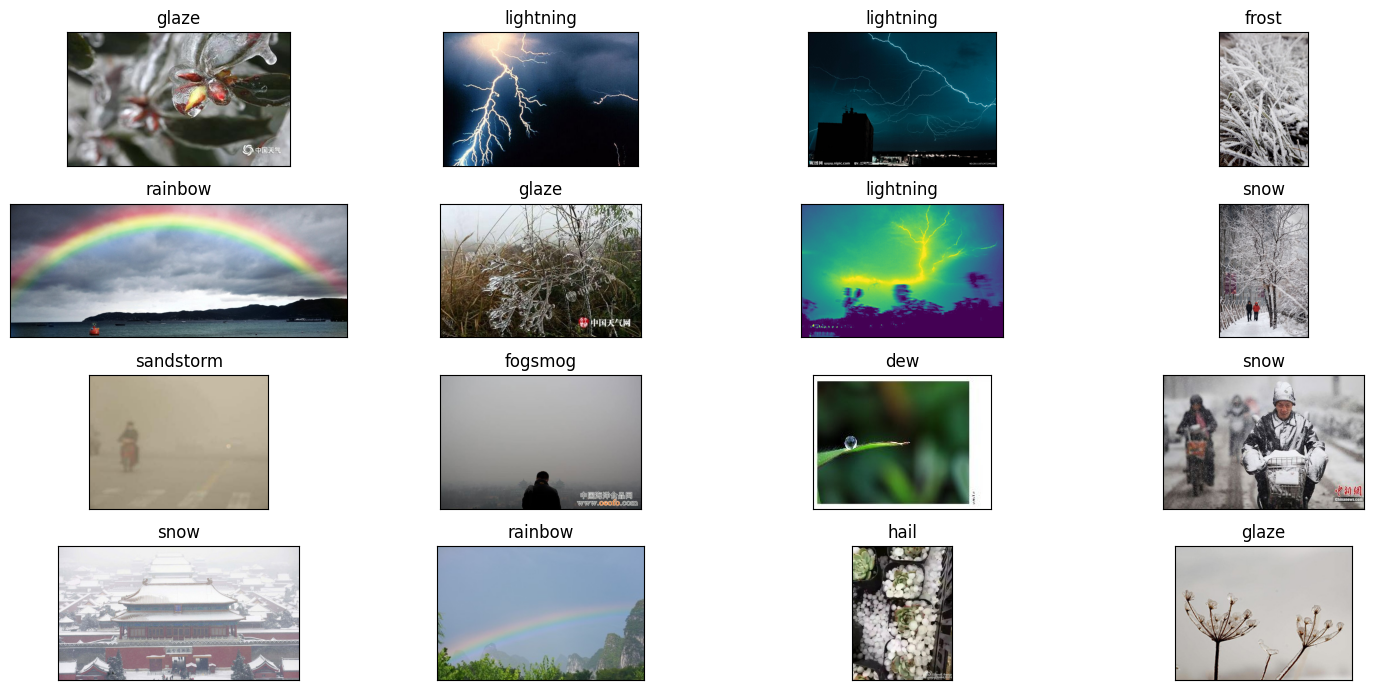

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,7), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Images[i]))
    ax.set_title(data.Labels[i])

plt.tight_layout()
plt.show()

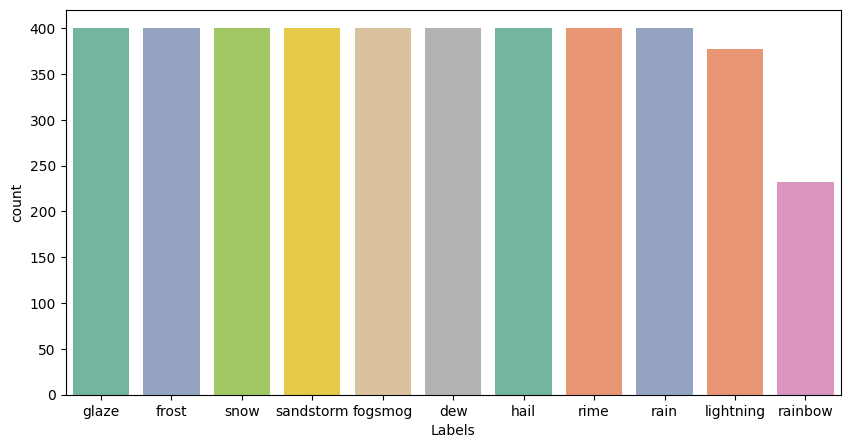

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x='Labels', data=data, order=data['Labels'].value_counts().index, palette='Set2', hue='Labels')
plt.show()

### ✂️ Train & Test Split ###

In [9]:
train_data,test_data = train_test_split(data, test_size=0.2, random_state=42)

### 🦾 Functions ###

In [10]:
# Data Generator

def data_generator(preprocessor, train, test, image_size):

    train_datagen = ImageDataGenerator(
        preprocessing_function = preprocessor,
        rotation_range = 30,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        validation_split = 0.2
    )

    test_datagen = ImageDataGenerator(preprocessing_function=preprocessor)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe = train,
        x_col = 'Images',
        y_col = 'Labels',
        shuffle = True,
        batch_size = 32,
        target_size = (image_size, image_size),
        subset = 'training',
        class_mode = 'categorical'
    )

    valid_gen = train_datagen.flow_from_dataframe(
        dataframe = train,
        x_col = 'Images',
        y_col = 'Labels',
        shuffle = True,
        batch_size = 32,
        target_size = (image_size, image_size),
        subset = 'validation',
        class_mode = 'categorical'
    )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe = test,
        x_col = 'Images',
        y_col = 'Labels',
        shuffle = False,
        batch_size = 32,
        target_size = (image_size, image_size),
        class_mode = 'categorical'
    )

    return train_gen, valid_gen, test_gen

In [11]:
# Model Function

len_labels = len(data['Labels'].unique())

def model_structure(model_name, image_size):
    model = model_name(weights='imagenet', input_shape=(image_size, image_size, 3), include_top = False)
    model.trainable = False
    input = model.input
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(len_labels, activation='softmax')(x)

    model = Model(inputs=input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    callback = [EarlyStopping(patience=2)]

    return model, callback

In [12]:
# Visualizing the results

def visualize_results(history, train_gen, test_gen, model):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sns.set_theme(style='whitegrid', rc={'axes.facecolor': '#5fa1bc'})

    ax[0].plot(history.history['accuracy'], label='Train accuracy', color='blue')
    ax[0].plot(history.history['val_accuracy'], label='Validation_Accuract', color='red')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss', color='blue')
    ax[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    pred = model.predict(test_gen)
    pred = np.argmax(pred, axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[i] for i in pred]

    cm = confusion_matrix(test_data['Labels'], pred)
    class_report = classification_report(test_data['Labels'], pred)

    print('Classificaiton Report: \n', class_report)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels.values(), yticklabels=labels.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,8), subplot_kw={'xticks':[], 'yticks':[]})

    for i, axes in enumerate(axes.flat):
        axes.imshow(plt.imread(test_data.Images.iloc[i+1]))
        axes.set_title(f'True: {test_data.Labels.iloc[i+1]} \n Predicted: {pred[i+1]}')

    plt.tight_layout()
    plt.show()

In [13]:
import json
def test_results(test_gen, model, model_name):
    results = model.evaluate(test_gen)
    #model_name = model.__class__.__name__
    results_dict = {
        'Test Loss': results[0],
        'Test Accuracy': results[1]
    }
    print(f'Test Loss: {results[0]:.2f}')
    print(f'Test Accuracy: {results[1]:.2f}')

    with open(f'/content/drive/MyDrive/results/{model_name}.json', 'w') as file:
        json.dump(results_dict, file)

    return results_dict

In [14]:
# Save the model
def save_model(model, model_name):
    with open(f'/content/drive/MyDrive/models/{model_name}.pkl', 'wb') as file:
        pickle.dump(model, file)

### 📚 Training models ###

### ✔️ EfficientNetB7 ###

In [15]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 600)
Enet_model, callback = model_structure(EfficientNetB7, 600)
history = Enet_model.fit(train_gen, validation_data=valid_gen,epochs=100, callbacks=callback)



Found 2694 validated image filenames belonging to 11 classes.
Found 673 validated image filenames belonging to 11 classes.
Found 842 validated image filenames belonging to 11 classes.
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 1245s 12s/step - accuracy: 0.4873 - loss: 1.5481 - val_accuracy: 0.7949 - val_loss: 0.5905
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.7794 - loss: 0.6213 - val_accuracy: 0.8291 - val_loss: 0.4615
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.7982 - loss: 0.5653 - val_accuracy: 0.8380 - val_loss: 0.4906
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.8177 - loss: 0.4808 - val_accuracy: 0.8380 - val_loss: 0.4559
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 368s 4s/step - accuracy: 0.8351 - loss: 0.4535 - val_accuracy: 0.8603 - val_loss: 0.3931
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.8582 - loss: 0.4072 - val_accuracy: 0.8559 - val_loss: 0.4209
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.8557 - loss: 0.4026 - val_accuracy: 0.8306 - val_loss: 0.4711


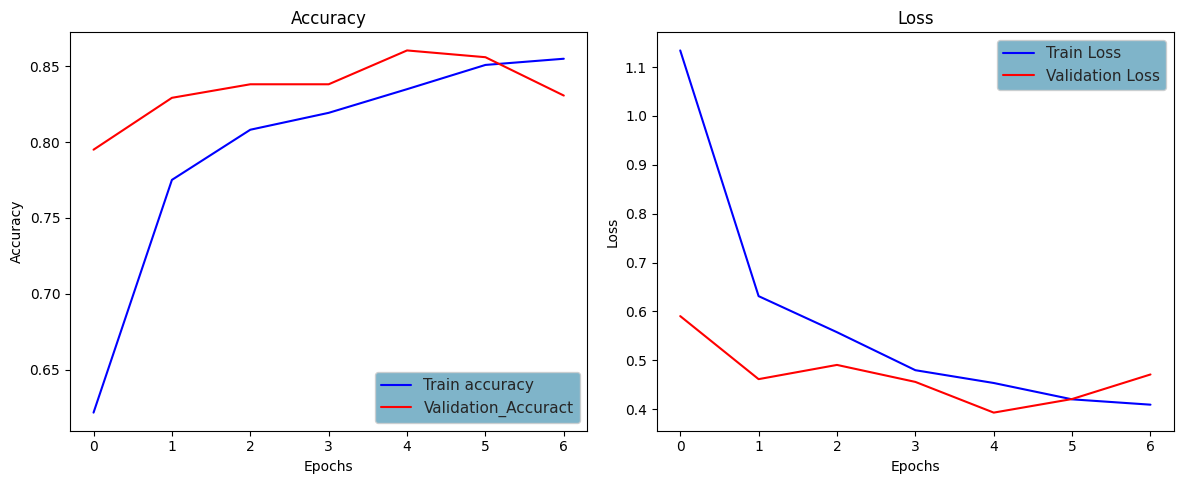

27/27 ━━━━━━━━━━━━━━━━━━━━ 242s 9s/step
Classificaiton Report: 
               precision    recall  f1-score   support

         dew       0.95      0.95      0.95        78
     fogsmog       0.74      0.73      0.74        83
       frost       0.89      0.81      0.85        80
       glaze       0.80      0.78      0.79        65
        hail       0.99      0.88      0.93        78
   lightning       0.95      0.99      0.97        73
        rain       0.78      0.96      0.86        80
     rainbow       0.96      0.94      0.95        47
        rime       0.76      0.93      0.83        80
   sandstorm       0.77      0.68      0.72        91
        snow       0.87      0.75      0.80        87

    accuracy                           0.85       842
   macro avg       0.86      0.85      0.85       842
weighted avg       0.85      0.85      0.85       842



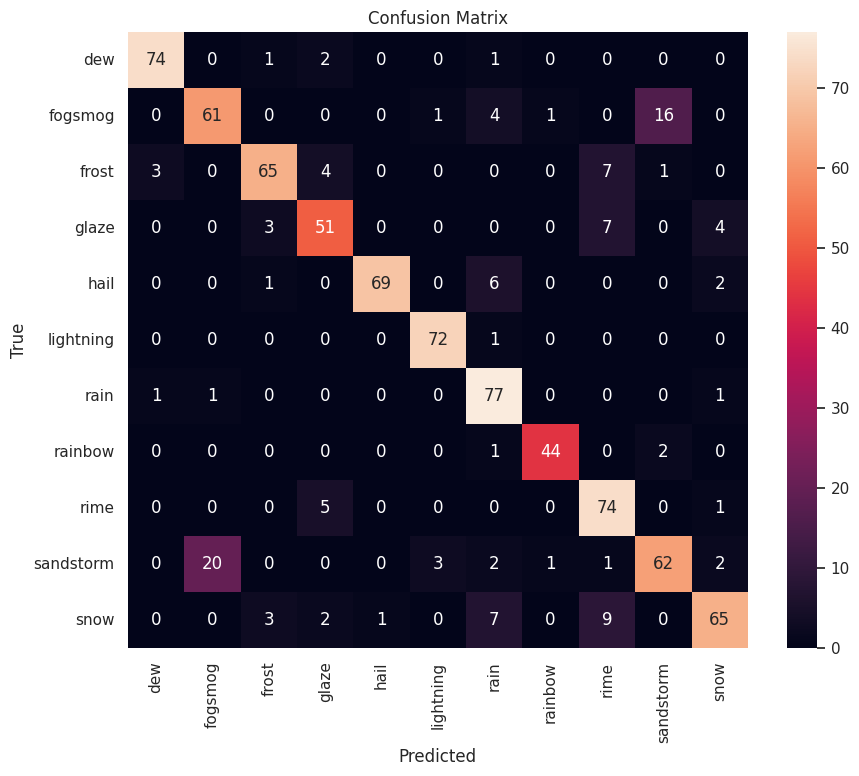

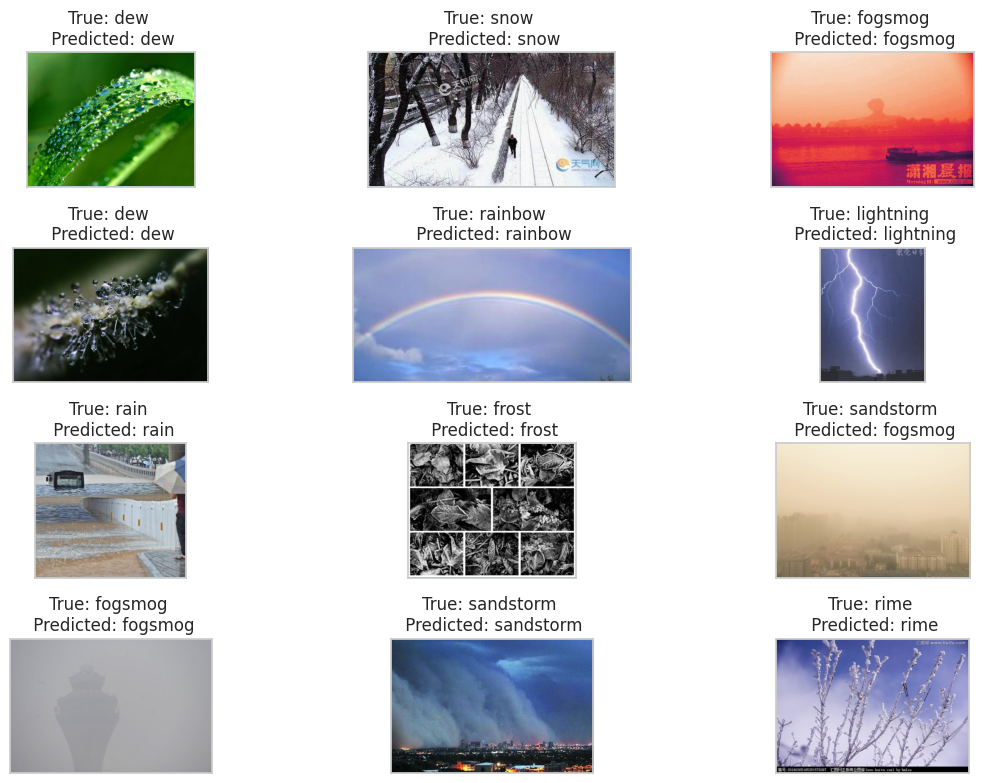

In [16]:
visualize_results(history, train_gen, test_gen, Enet_model)

In [17]:
result_enet = test_results(test_gen, Enet_model, 'Efficient_model')
save_model(Enet_model,'Efficient_model')

27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8506 - loss: 0.4006
Test Loss: 0.40
Test Accuracy: 0.85


### ✔️ ResNet50 ###

Found 2694 validated image filenames belonging to 11 classes.
Found 673 validated image filenames belonging to 11 classes.
Found 842 validated image filenames belonging to 11 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 84s 799ms/step - accuracy: 0.3829 - loss: 1.9754 - val_accuracy: 0.8172 - val_loss: 0.5813
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 72s 765ms/step - accuracy: 0.7220 - loss: 0.7927 - val_accuracy: 0.8276 - val_loss: 0.5016
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 59s 656ms/step - accuracy: 0.7706 - loss: 0.7108 - val_accuracy: 0.8232 - val_loss: 0.4689
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 92s 764ms/step - accuracy: 0.8035 - loss: 0.5961 - val_accuracy: 0.8366 - val_loss: 0.4736
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 59s 655ms/step - accuracy: 0.8242 - loss: 0.5230 - val_accuracy: 0.8455 - val_loss: 0.4367
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 677ms/step - accuracy: 0.8317 - loss: 0.5008 - val_accuracy: 0.8603 - val_loss: 0.4006
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 653ms/step - accuracy: 0.8327 - loss: 0.4915 - val_accuracy: 0.8559 - val_loss: 0.4531
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 59s 661ms/step - accuracy: 0.8528 - loss: 0.4261 - val_accuracy

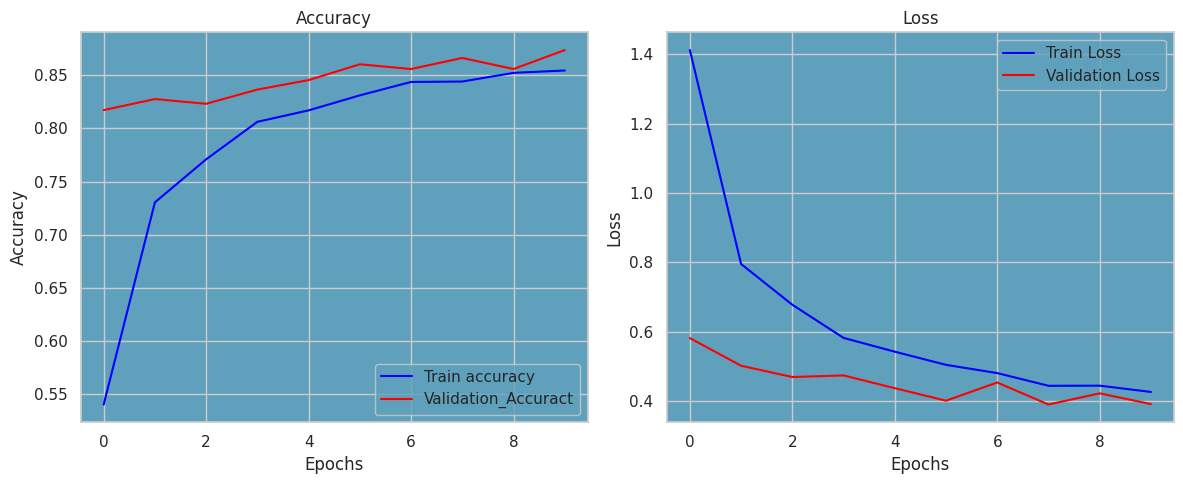

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step
Classificaiton Report: 
               precision    recall  f1-score   support

         dew       0.97      0.90      0.93        78
     fogsmog       0.92      0.83      0.87        83
       frost       0.80      0.89      0.84        80
       glaze       0.74      0.74      0.74        65
        hail       0.99      0.90      0.94        78
   lightning       0.99      1.00      0.99        73
        rain       0.89      0.88      0.88        80
     rainbow       0.96      1.00      0.98        47
        rime       0.82      0.94      0.88        80
   sandstorm       0.92      0.95      0.93        91
        snow       0.82      0.79      0.81        87

    accuracy                           0.89       842
   macro avg       0.89      0.89      0.89       842
weighted avg       0.89      0.89      0.89       842



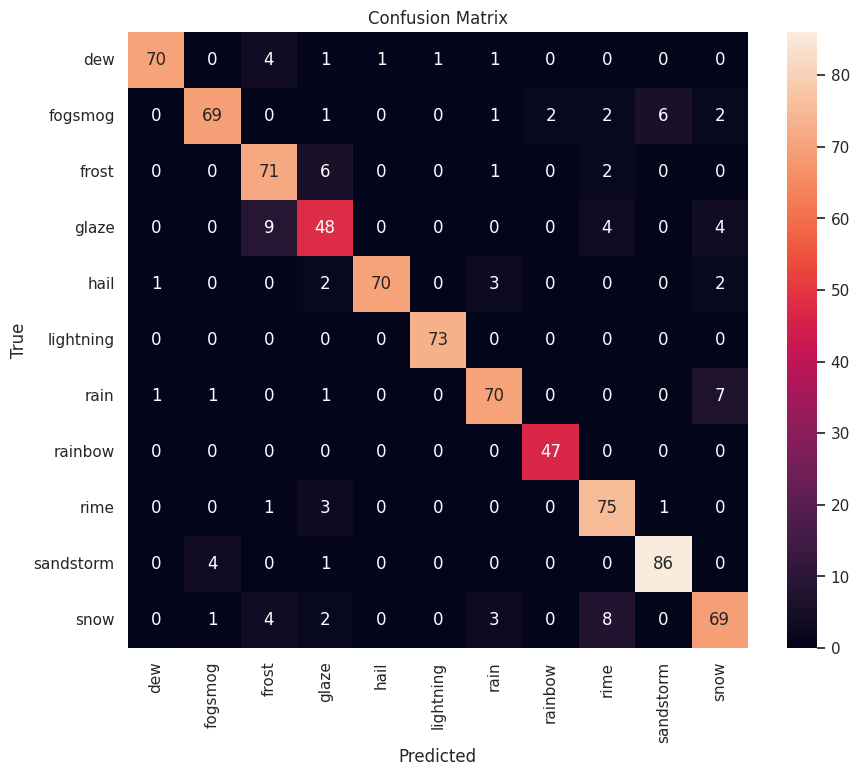

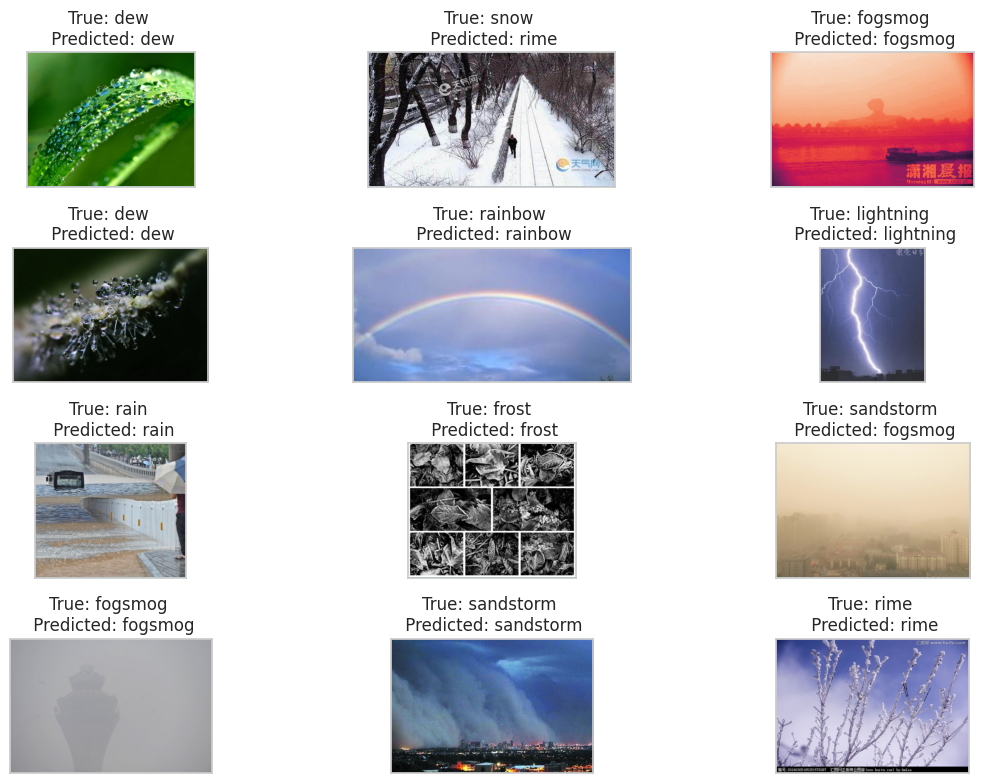

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.8826 - loss: 0.3626
Test Loss: 0.36
Test Accuracy: 0.89


In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 224)
resnet50_model, callback = model_structure(ResNet50, 224)
history = resnet50_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)
visualize_results(history, train_gen, test_gen, resnet50_model)
results_resnet50 = test_results(test_gen, resnet50_model, 'ResNet50')
save_model(resnet50_model, 'ResNet50')

### ✔️ResNet152V2 ###

Found 2694 validated image filenames belonging to 11 classes.
Found 673 validated image filenames belonging to 11 classes.
Found 842 validated image filenames belonging to 11 classes.
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.0813 - loss: 217.5970 - val_accuracy: 0.0877 - val_loss: 2.3981
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 76s 836ms/step - accuracy: 0.0913 - loss: 2.4165 - val_accuracy: 0.0877 - val_loss: 2.3963
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 75s 835ms/step - accuracy: 0.1081 - loss: 2.3936 - val_accuracy: 0.0877 - val_loss: 2.3952
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 907ms/step - accuracy: 0.1080 - loss: 2.3907 - val_accuracy: 0.0892 - val_loss: 2.3958
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 76s 845ms/step - accuracy: 0.1034 - loss: 2.3902 - val_accuracy: 0.0906 - val_loss: 2.3945
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 87s 905ms/step - accuracy: 0.0943 - loss: 2.3886 - val_accuracy: 0.0877 - val_loss: 2.3953
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 76s 850ms/step - accuracy: 0.0931 - loss: 2.5058 - val_accuracy: 0.0892 - val_loss: 2.3949


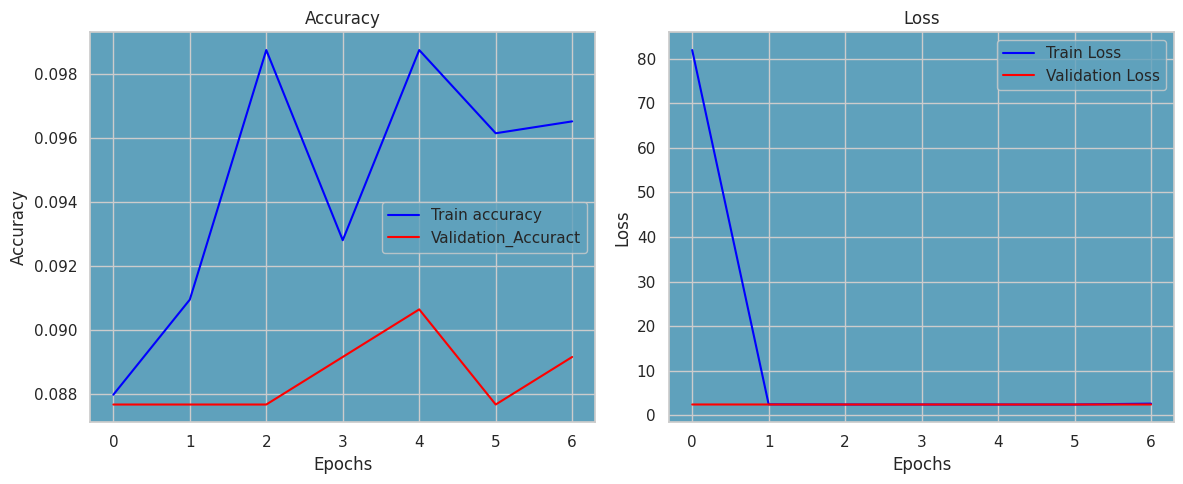

27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 632ms/step
Classificaiton Report: 
               precision    recall  f1-score   support

         dew       0.00      0.00      0.00        78
     fogsmog       0.00      0.00      0.00        83
       frost       0.00      0.00      0.00        80
       glaze       0.00      0.00      0.00        65
        hail       0.00      0.00      0.00        78
   lightning       0.00      0.00      0.00        73
        rain       0.00      0.00      0.00        80
     rainbow       0.00      0.00      0.00        47
        rime       0.10      1.00      0.17        80
   sandstorm       0.00      0.00      0.00        91
        snow       0.00      0.00      0.00        87

    accuracy                           0.10       842
   macro avg       0.01      0.09      0.02       842
weighted avg       0.01      0.10      0.02       842



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


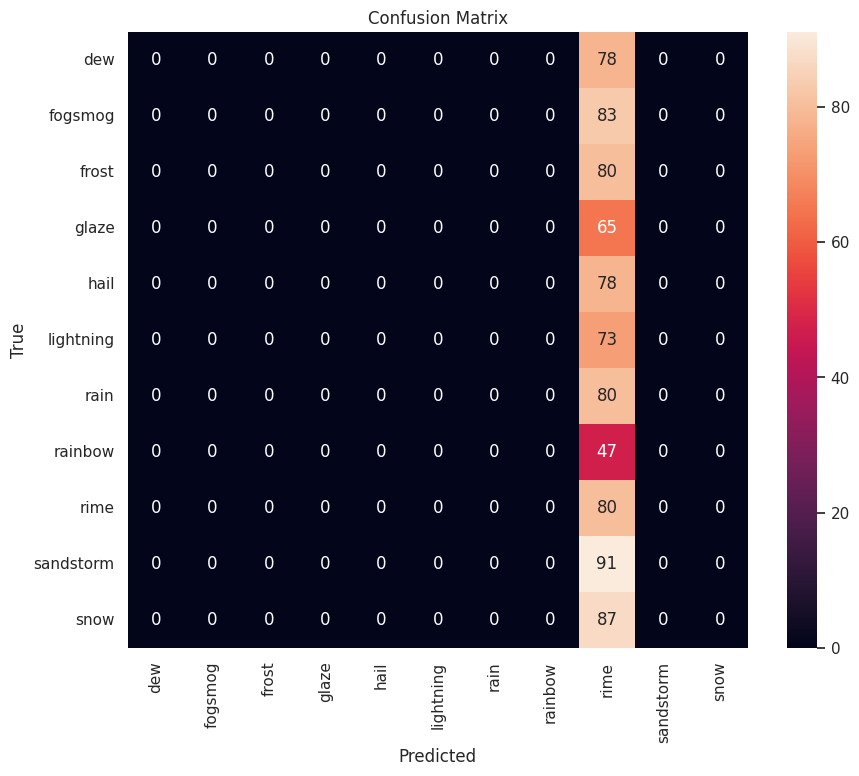

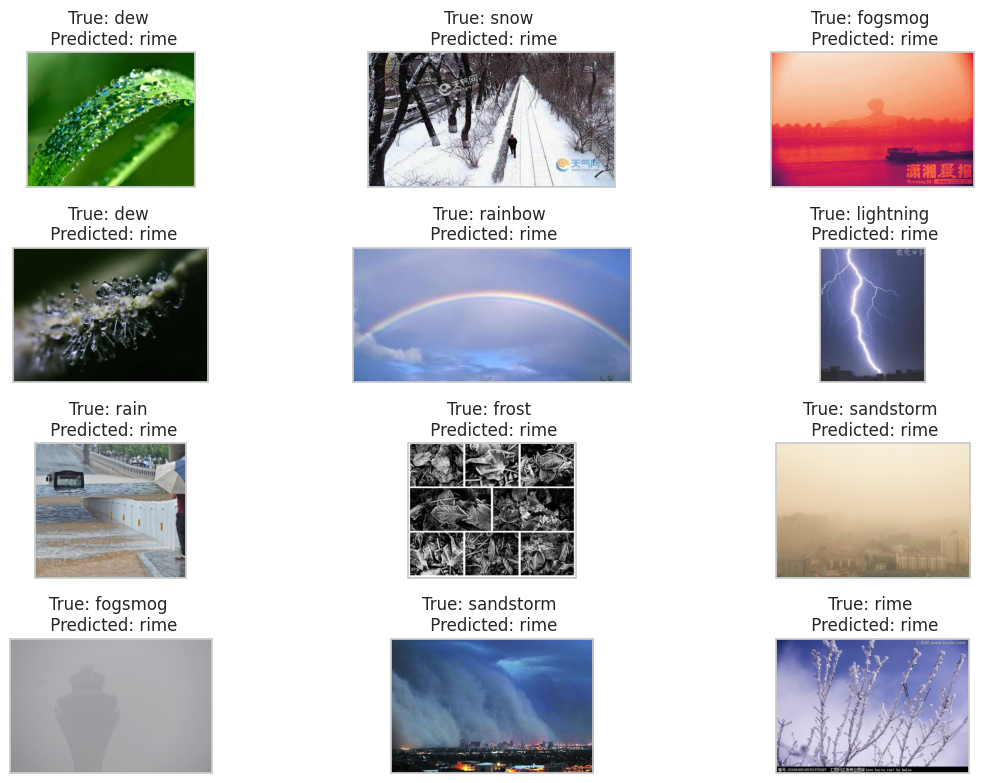

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.1012 - loss: 2.3928
Test Loss: 2.39
Test Accuracy: 0.10


In [19]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 256)
resnet152_model, callback = model_structure(ResNet152V2, 256)
history = resnet152_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)
visualize_results(history, train_gen, test_gen, resnet152_model)
results_resnet152 = test_results(test_gen, resnet152_model, 'Resnet152V2')
save_model(resnet152_model, 'Resnet152V2')

### ✔️ MobileNet ###

Found 2694 validated image filenames belonging to 11 classes.
Found 673 validated image filenames belonging to 11 classes.
Found 842 validated image filenames belonging to 11 classes.
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 78s 763ms/step - accuracy: 0.3368 - loss: 1.9963 - val_accuracy: 0.7712 - val_loss: 0.7330
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 58s 643ms/step - accuracy: 0.6837 - loss: 0.9231 - val_accuracy: 0.7949 - val_loss: 0.5614
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 90s 738ms/step - accuracy: 0.7358 - loss: 0.7810 - val_accuracy: 0.8202 - val_loss: 0.4866
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 73s 633ms/step - accuracy: 0.7811 - loss: 0.6376 - val_accuracy: 0.8380 - val_loss: 0.4986
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 57s 633ms/step - accuracy: 0.7982 - loss: 0.5864 - val_accuracy: 0.8232 - val_loss: 0.4545
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 59s 658ms/step - accuracy: 0.8133 - loss: 0.5626 - val_accuracy: 0.8470 - val_loss: 0.4358
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 57s 619ms/step - accuracy: 0.8027 - loss: 0.5456 - val_accuracy: 0.8692 - val_loss: 0.4102
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 626ms/step - accuracy: 0.8290 - loss: 0.4821 - val_accuracy

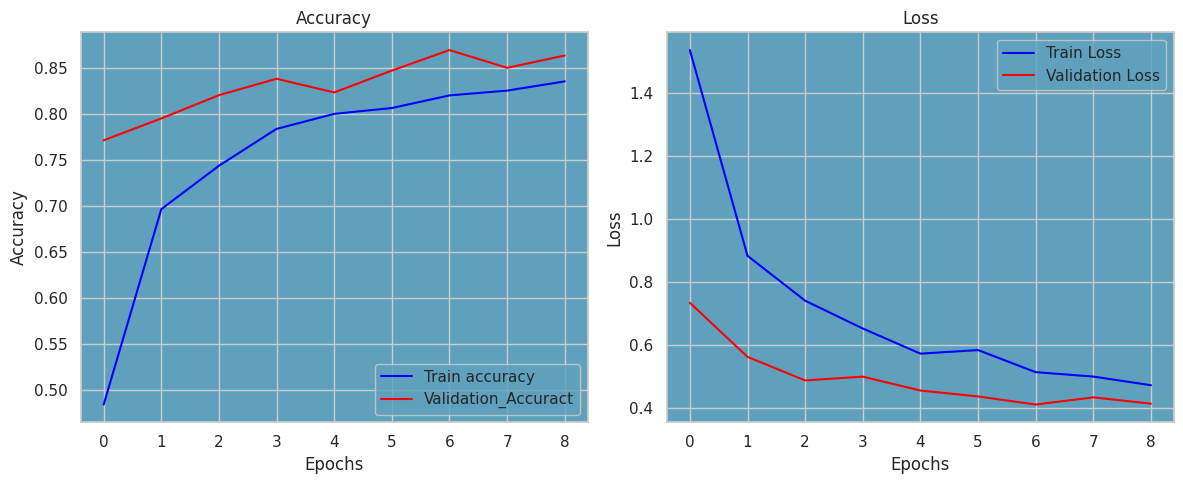

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step
Classificaiton Report: 
               precision    recall  f1-score   support

         dew       0.99      0.94      0.96        78
     fogsmog       0.91      0.87      0.89        83
       frost       0.88      0.85      0.87        80
       glaze       0.76      0.77      0.76        65
        hail       0.95      0.91      0.93        78
   lightning       0.99      1.00      0.99        73
        rain       0.85      0.84      0.84        80
     rainbow       1.00      0.96      0.98        47
        rime       0.76      0.86      0.81        80
   sandstorm       0.92      0.90      0.91        91
        snow       0.80      0.85      0.82        87

    accuracy                           0.88       842
   macro avg       0.89      0.89      0.89       842
weighted avg       0.89      0.88      0.88       842



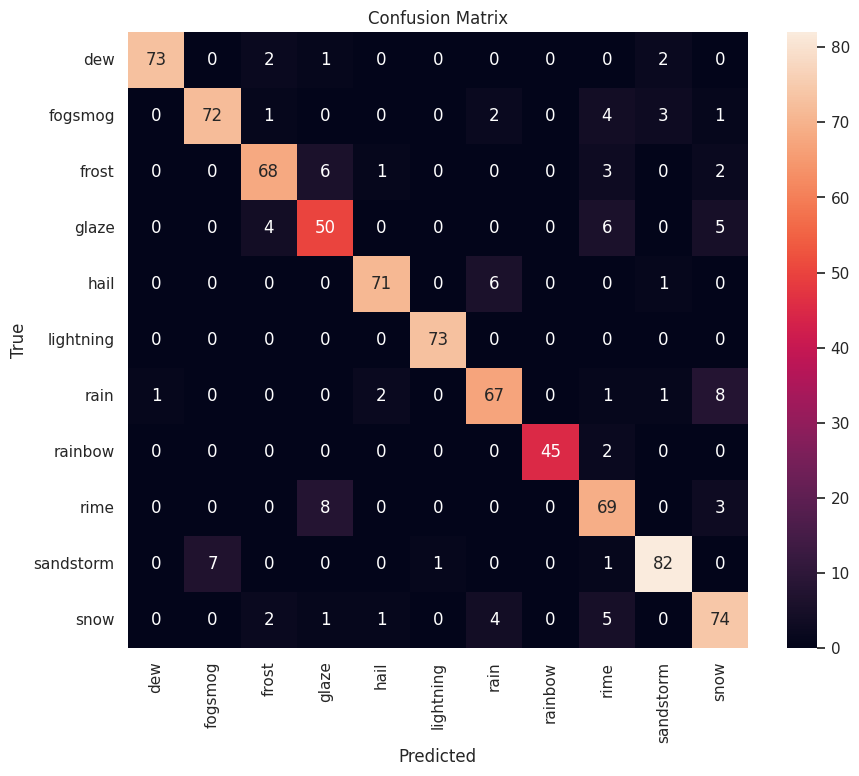

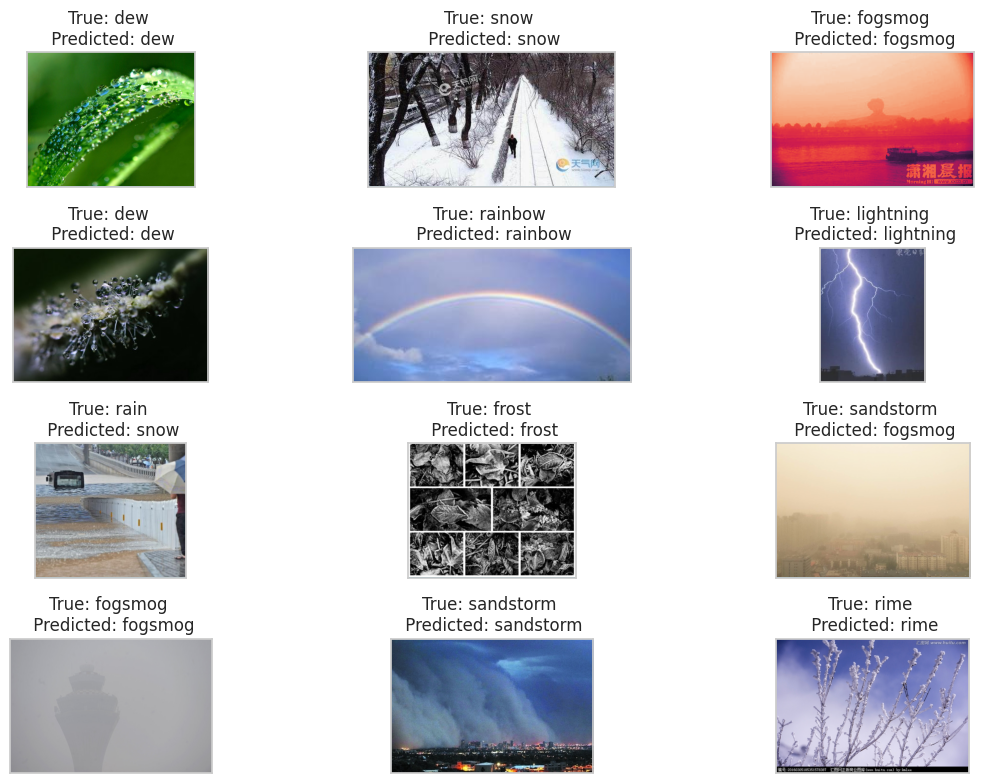

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.8651 - loss: 0.3501
Test Loss: 0.34
Test Accuracy: 0.88


In [20]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 224)
mobilenet_model, callback = model_structure(MobileNet, 224)
history = mobilenet_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)

visualize_results(history, train_gen, test_gen, mobilenet_model)
results_mobilenet = test_results(test_gen, mobilenet_model, 'MobileNet')
save_model(mobilenet_model, 'MobileNet')

### ✔️ VGG19 ###

Found 2694 validated image filenames belonging to 11 classes.
Found 673 validated image filenames belonging to 11 classes.
Found 842 validated image filenames belonging to 11 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 100s 912ms/step - accuracy: 0.2587 - loss: 3.4023 - val_accuracy: 0.6538 - val_loss: 1.0671
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 74s 822ms/step - accuracy: 0.5737 - loss: 1.2890 - val_accuracy: 0.7281 - val_loss: 0.7831
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 71s 706ms/step - accuracy: 0.6459 - loss: 1.0594 - val_accuracy: 0.7845 - val_loss: 0.6984
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 690ms/step - accuracy: 0.6887 - loss: 0.9453 - val_accuracy: 0.7890 - val_loss: 0.6465
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 84s 716ms/step - accuracy: 0.7388 - loss: 0.8109 - val_accuracy: 0.8128 - val_loss: 0.5603
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 78s 681ms/step - accuracy: 0.7394 - loss: 0.7603 - val_accuracy: 0.7994 - val_loss: 0.5890
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 696ms/step - accuracy: 0.7566 - loss: 0.6878 - val_accuracy: 0.8262 - val_loss: 0.5434
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 714ms/step - accuracy: 0.7827 - loss: 0.6605 - val_accurac

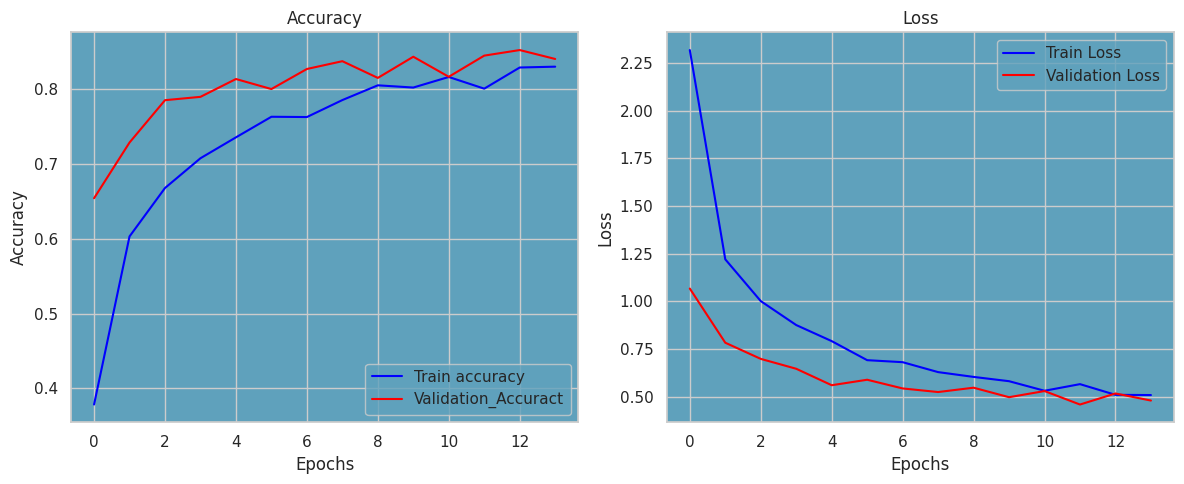

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 471ms/step
Classificaiton Report: 
               precision    recall  f1-score   support

         dew       0.97      0.91      0.94        78
     fogsmog       0.86      0.87      0.86        83
       frost       0.78      0.82      0.80        80
       glaze       0.67      0.69      0.68        65
        hail       0.97      0.91      0.94        78
   lightning       0.96      0.96      0.96        73
        rain       0.86      0.89      0.87        80
     rainbow       0.96      0.98      0.97        47
        rime       0.78      0.89      0.83        80
   sandstorm       0.93      0.86      0.89        91
        snow       0.83      0.77      0.80        87

    accuracy                           0.86       842
   macro avg       0.87      0.87      0.87       842
weighted avg       0.87      0.86      0.87       842



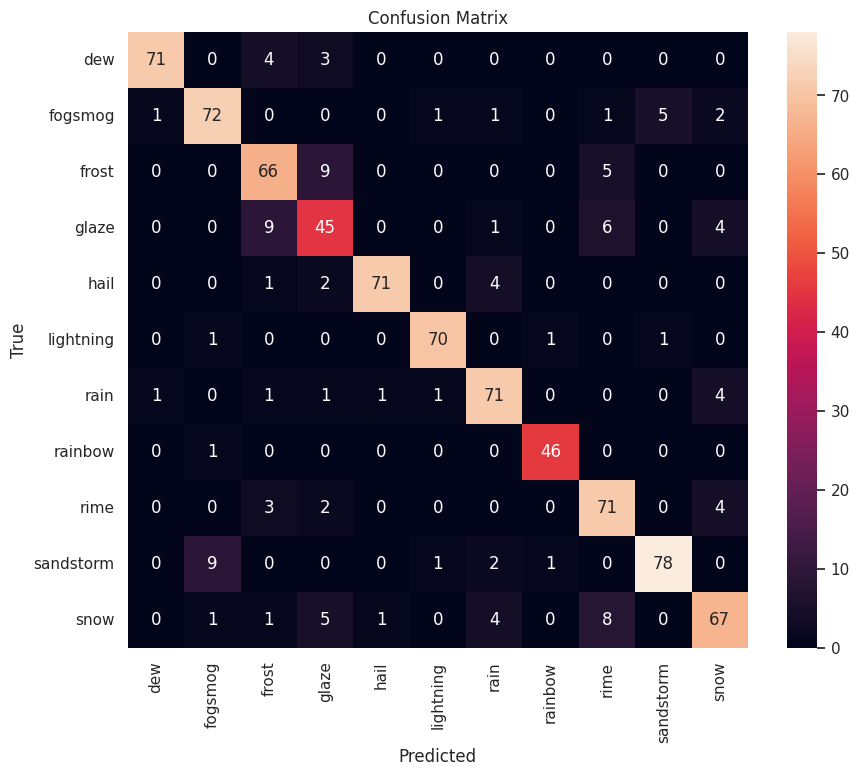

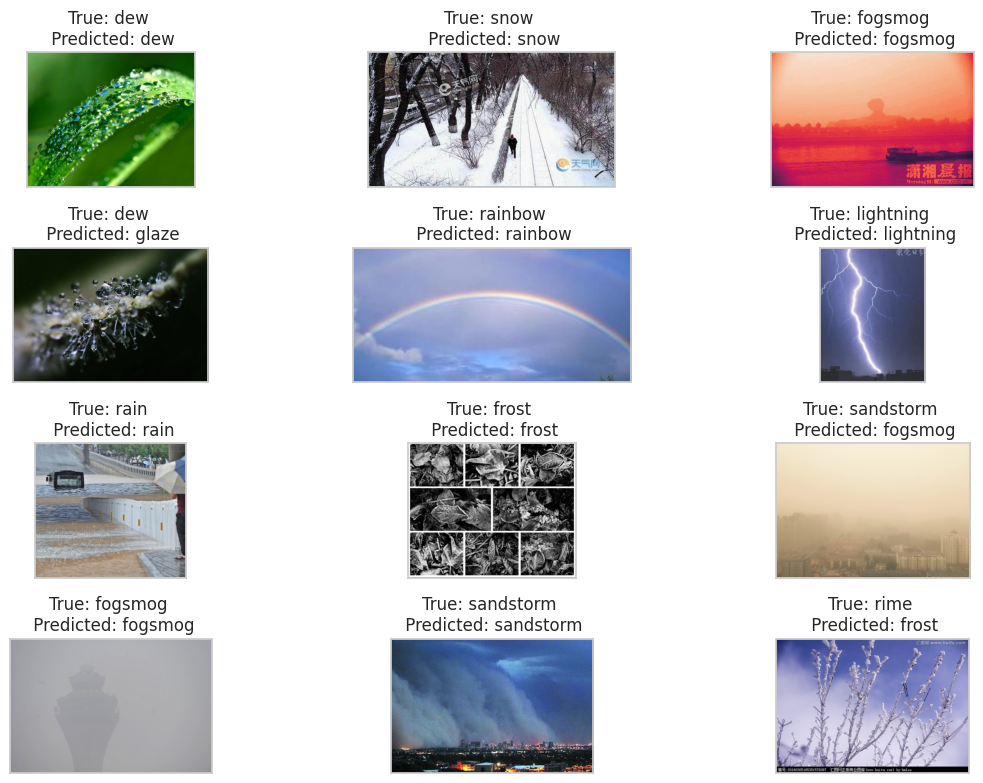

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.8574 - loss: 0.4250
Test Loss: 0.42
Test Accuracy: 0.86


In [21]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 224)
vgg19_model, callback = model_structure(VGG19, 224)
history = vgg19_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)
visualize_results(history, train_gen, test_gen, vgg19_model)
results_vgg19 = test_results(test_gen, vgg19_model,'VGG19')
save_model(vgg19_model,'VGG19')

### ✔️ Xception ###

Found 2694 validated image filenames belonging to 11 classes.
Found 673 validated image filenames belonging to 11 classes.
Found 842 validated image filenames belonging to 11 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3321 - loss: 1.8871 - val_accuracy: 0.7385 - val_loss: 0.7948
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7271 - loss: 0.8264 - val_accuracy: 0.8009 - val_loss: 0.5933
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7464 - loss: 0.7380 - val_accuracy: 0.8113 - val_loss: 0.5274
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7730 - loss: 0.6504 - val_accuracy: 0.8262 - val_loss: 0.5097
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7954 - loss: 0.5925 - val_accuracy: 0.8321 - val_loss: 0.4892
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8019 - loss: 0.5788 - val_accuracy: 0.8366 - val_loss: 0.5013
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8270 - loss: 0.5088 - val_accuracy: 0.8499 - val_loss: 0.4450
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8030 - loss: 0.5780 - val_accuracy: 0.8574 - val_loss:

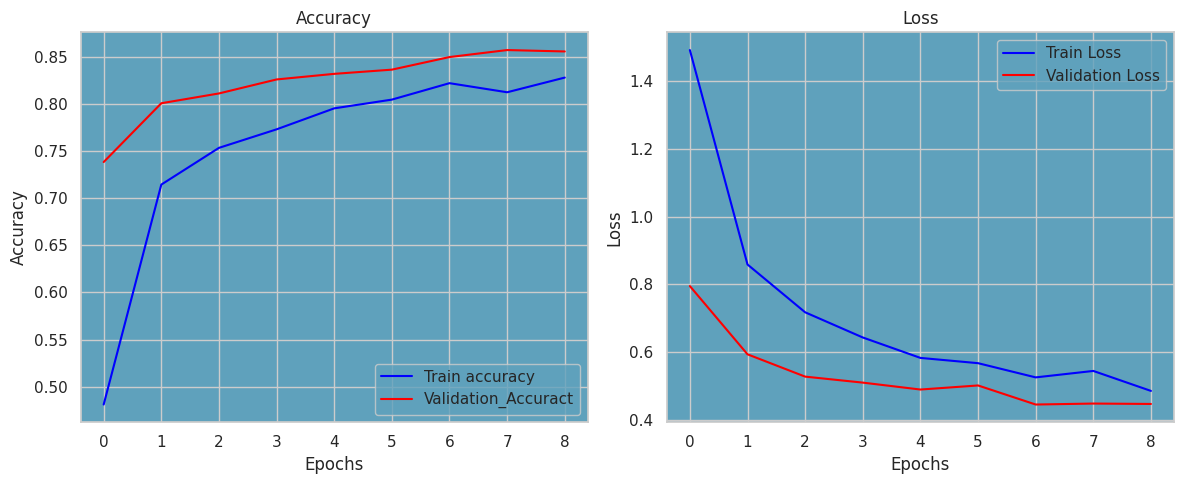

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 613ms/step
Classificaiton Report: 
               precision    recall  f1-score   support

         dew       0.95      0.91      0.93        78
     fogsmog       0.79      0.81      0.80        83
       frost       0.79      0.82      0.80        80
       glaze       0.69      0.65      0.67        65
        hail       0.96      0.88      0.92        78
   lightning       0.89      0.96      0.92        73
        rain       0.84      0.80      0.82        80
     rainbow       0.98      0.87      0.92        47
        rime       0.85      0.76      0.80        80
   sandstorm       0.77      0.81      0.79        91
        snow       0.74      0.85      0.79        87

    accuracy                           0.83       842
   macro avg       0.84      0.83      0.83       842
weighted avg       0.83      0.83      0.83       842



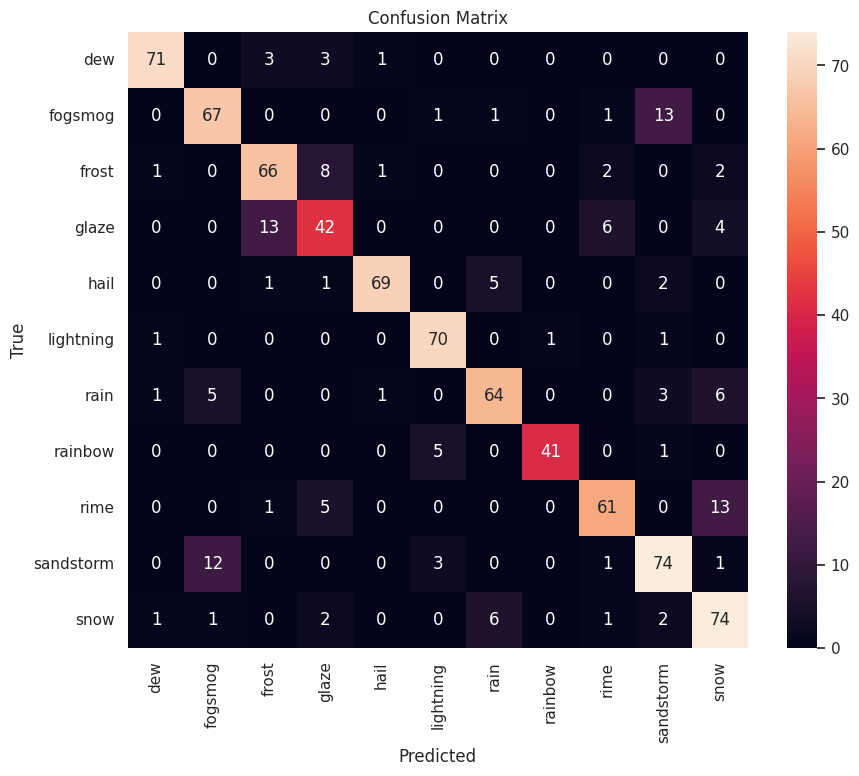

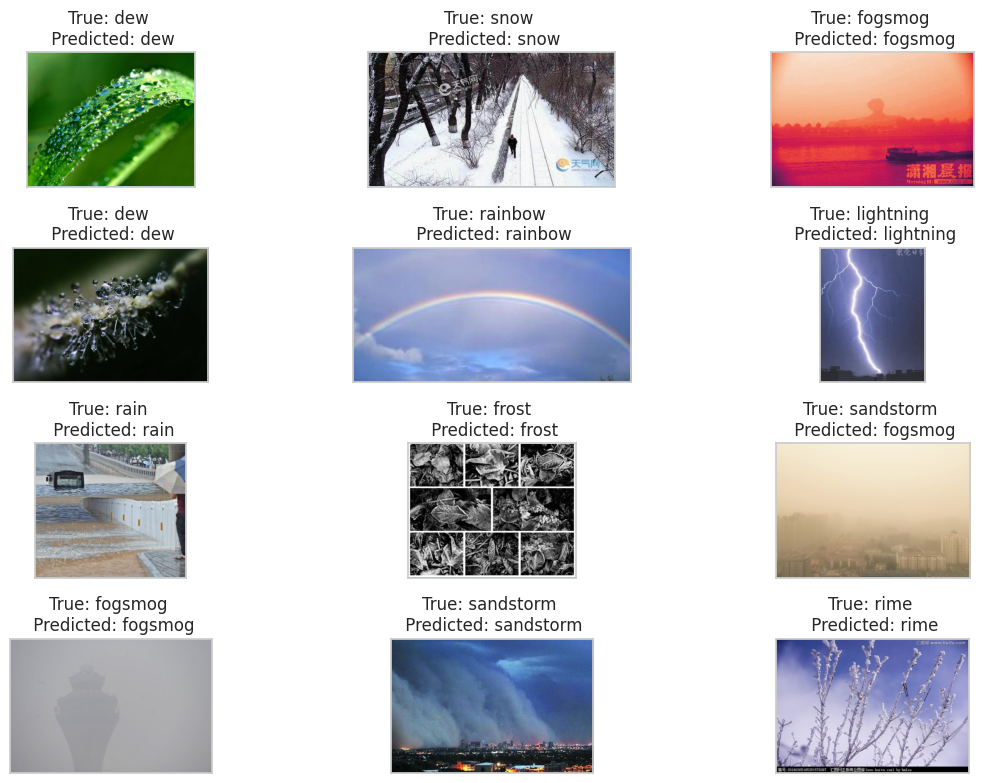

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.8190 - loss: 0.5070
Test Loss: 0.48
Test Accuracy: 0.83


In [22]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 299)
xception_model, callback = model_structure(Xception, 299)
history = xception_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)
visualize_results(history, train_gen, test_gen, xception_model)
results_xception = test_results(test_gen, xception_model,'Xception')
save_model(xception_model,'Xception')

### ✔️ InceptionResNetV2 ###

Found 2694 validated image filenames belonging to 11 classes.
Found 673 validated image filenames belonging to 11 classes.
Found 842 validated image filenames belonging to 11 classes.
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.2974 - loss: 2.0402 - val_accuracy: 0.6984 - val_loss: 0.9608
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6238 - loss: 1.0922 - val_accuracy: 0.7504 - val_loss: 0.7302
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6898 - loss: 0.8914 - val_accuracy: 0.7548 - val_loss: 0.6944
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7129 - loss: 0.8453 - val_accuracy: 0.7816 - val_loss: 0.6201
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7350 - loss: 0.7917 - val_accuracy: 0.8039 - val_loss: 0.5668
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7508 - loss: 0.6903 - val_accuracy: 0.8247 - val_loss: 0.5350
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7495 - loss: 0.7006 - val_accuracy: 0.8232 - val_loss: 0.5269
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7792 - loss: 0.6520 - val_accuracy: 0.8053 - val_los

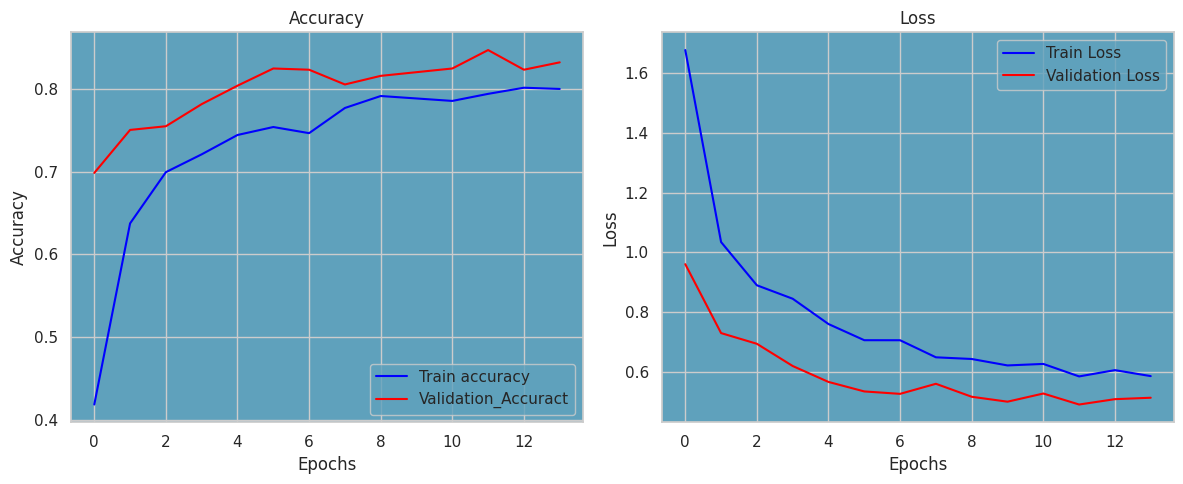

27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 865ms/step
Classificaiton Report: 
               precision    recall  f1-score   support

         dew       0.96      0.91      0.93        78
     fogsmog       0.71      0.84      0.77        83
       frost       0.85      0.78      0.81        80
       glaze       0.68      0.77      0.72        65
        hail       0.92      0.88      0.90        78
   lightning       0.96      0.90      0.93        73
        rain       0.80      0.84      0.82        80
     rainbow       0.91      0.85      0.88        47
        rime       0.88      0.81      0.84        80
   sandstorm       0.76      0.75      0.75        91
        snow       0.79      0.78      0.79        87

    accuracy                           0.83       842
   macro avg       0.84      0.83      0.83       842
weighted avg       0.83      0.83      0.83       842



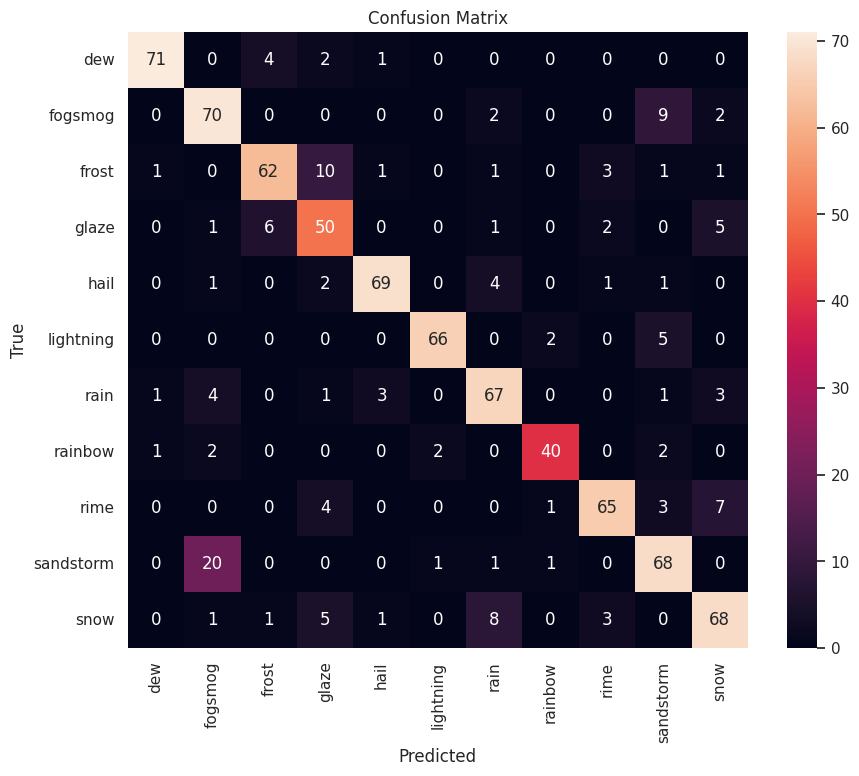

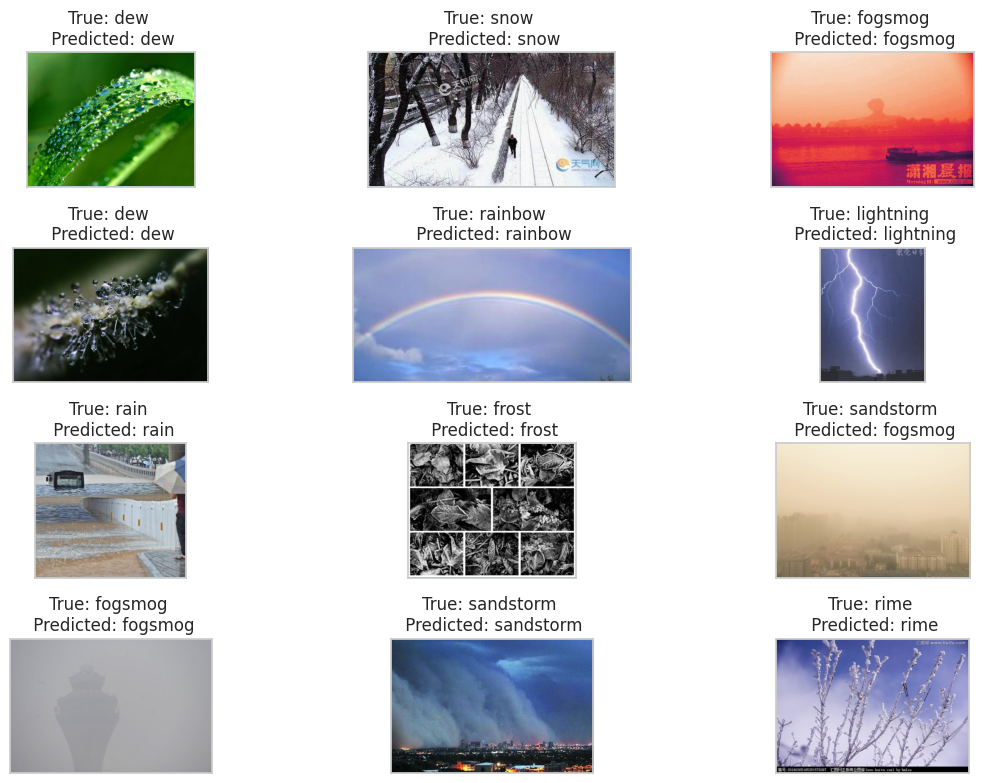

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 499ms/step - accuracy: 0.8124 - loss: 0.5169
Test Loss: 0.51
Test Accuracy: 0.83


In [23]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 299)
inception_model, callback = model_structure(InceptionResNetV2, 299)
history = inception_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)
visualize_results(history, train_gen, test_gen, inception_model)
results_inception = test_results(test_gen, inception_model,'InceptionResNetV2')
save_model(inception_model,'InceptionResNetV2')

### ✔️ VGG16 ###

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 224)
vgg16_model, callback = model_structure(VGG16, 224)
history = vgg16_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)
visualize_results(history, train_gen, test_gen, vgg16_model)
results_vgg16 = test_results(test_gen, vgg16_model,'VGG16')
save_model(vgg16_model,'VGG16')

Found 2694 validated image filenames belonging to 11 classes.
Found 673 validated image filenames belonging to 11 classes.
Found 842 validated image filenames belonging to 11 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 79s 816ms/step - accuracy: 0.2435 - loss: 3.5115 - val_accuracy: 0.6790 - val_loss: 1.0284
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 701ms/step - accuracy: 0.5818 - loss: 1.2528 - val_accuracy: 0.7533 - val_loss: 0.7837
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 681ms/step - accuracy: 0.6778 - loss: 0.9751 - val_accuracy: 0.7727 - val_loss: 0.6887
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 85s 719ms/step - accuracy: 0.6933 - loss: 0.9189 - val_accuracy: 0.7771 - val_loss: 0.6241
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 688ms/step - accuracy: 0.7324 - loss: 0.8058 - val_accuracy: 0.8024 - val_loss: 0.5842
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 71s 804ms/step - accuracy: 0.7911 - loss: 0.6456 - val_accuracy: 0.8009 - val_loss: 0.5676
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 694ms/step - accuracy: 0.7570 - loss: 0.6843 - val_accuracy: 0.8009 - val_loss: 0.5547
Epoch 8/100
11/85 ━━━━━━━━━━━━━━━━━━━━ 35s 485ms/step - accuracy: 0.7936 - loss: 0.5794

KeyboardInterrupt: 

### ✔️ ResNet101 ###

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 224)
resent101_model, callback = model_structure(ResNet101, 224)
history = resent101_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)
visualize_results(history, train_gen, test_gen, resent101_model)
results_resent101 = test_results(test_gen, resent101_model,'ResNet101')
save_model(resent101_model,'ResNet101')

### ✔️ DenseNet201 ###

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

train_gen, valid_gen, test_gen = data_generator(preprocess_input, train_data, test_data, 224)
densenet201_model, callback = model_structure(DenseNet201, 224)
history = densenet201_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=callback
)
visualize_results(history, train_gen, test_gen, densenet201_model)
results_densenet201 = test_results(test_gen, densenet201_model,'DenseNet201')
save_model(densenet201_model,'DenseNet201')